In [1]:
import pandas as pd

clients = pd.read_excel('clients.xlsx')

columns = ['1 day (день регистрации)',
          '2 day (день второго визита в клуб)',
          'max day (дата последнего визита)']

for col in columns:
    clients[col] = pd.to_datetime(clients[col],
                                  unit='D',
                                  origin='1899-12-30')

clients.head()

,ID,Проигрыш (первое посещение),IN (первое посещение),Ставки за бонусы (первое посещение),Депозит (первое посещение),вывод средств (первое посещение),"№ клуба, который посетил в первый день регистрации в сети",1 day (день регистрации),2 day (день второго визита в клуб),max day (дата последнего визита),"Кол-во визитов (за все время, не считая 1й визит)",Проигрыш за все визиты,Ожидаемый проигрыш
0,2430961840,8388000.0,25257600.0,0,8400000.0,12000.0,1731,2021-02-02,2021-02-04,2021-03-09,19,19351152.0,1.733383e+07
1,2457041912,1071050.0,7140850.0,0,1635250.0,465000.0,1700,2020-10-26,2020-10-27,2020-11-30,3,554900.0,9.792799e+04
2,2457572945,826800.0,2268210.0,600,856800.0,30000.0,70,2021-03-05,2021-03-07,2021-03-12,4,130560.0,4.050973e+05
3,2431814793,895900.0,3094265.0,0,1156300.0,260400.0,1227,2020-08-18,2020-08-21,2021-02-01,11,188960.5,1.944108e+05
4,2446261140,600000.0,1624920.0,0,600000.0,0.0,1823,2020-12-06,2020-12-10,2021-02-05,6,-15654.0,-4.059306e+04


Посчитаем средний проигрыш клиента.

In [2]:
clients['all_visits'] = clients['Кол-во визитов (за все время, не считая 1й визит)'] + 1
clients['avg_profit'] = clients['Проигрыш за все визиты'] / clients['all_visits']

clients[['all_visits', 'avg_profit']].describe()

,all_visits,avg_profit
count,83038.000000,8.303800e+04
mean,4.865556,5.473033e+02
std,11.955614,1.224774e+04
min,1.000000,-2.100000e+06
25%,1.000000,0.000000e+00
50%,1.000000,0.000000e+00
75%,3.000000,3.875000e+02
max,223.000000,9.675576e+05


In [3]:
clients[(clients['Депозит (первое посещение)'] == 0) & (
    clients['Ставки за бонусы (первое посещение)'] == 0)].shape

(22, 15)

Taкже посчитаем отношение оброта в первый день к депозиту. Чем оно больше, тем чаще клиент выигранные деньги (если они есть) использует в последующих ставках, а не выводит их или просто хранит. Соотвественно, в какой-то момент он всё может проиграть и, возможно, занести ещё своих денег на новые ставки.

Часть людей при первом посещение вообще не делала депозита, в качестве него для них возьмём ставку за бонусы.

Есть ещё **22** клиента, у которых ни депозита, ни бонусов при первом посещении, но есть оборот. Выглядит как ошибка - удалим эти записи.

In [4]:
clean_clients = clients[(clients['Депозит (первое посещение)'] != 0) & (
    clients['Ставки за бонусы (первое посещение)'] != 0)].copy()

clean_clients['in_dep_ratio'] = clean_clients['IN (первое посещение)'] / (
    clean_clients['Депозит (первое посещение)'] + clean_clients['Ставки за бонусы (первое посещение)'])

clean_clients['in_dep_ratio'].describe()

count    30513.000000
mean         2.576312
std          3.901816
min          0.000000
25%          0.861111
50%          1.489655
75%          2.885886
max        118.745455
Name: in_dep_ratio, dtype: float64

Предполагая, что средний проигрыш, кол-во визитов и коэф. оборот/депо характерихуют некоторую "азартность" клиента, построим графики рассеяния для этих величин. 

array([[<AxesSubplot:xlabel='all_visits', ylabel='all_visits'>,
        <AxesSubplot:xlabel='avg_profit', ylabel='all_visits'>,
        <AxesSubplot:xlabel='in_dep_ratio', ylabel='all_visits'>],
       [<AxesSubplot:xlabel='all_visits', ylabel='avg_profit'>,
        <AxesSubplot:xlabel='avg_profit', ylabel='avg_profit'>,
        <AxesSubplot:xlabel='in_dep_ratio', ylabel='avg_profit'>],
       [<AxesSubplot:xlabel='all_visits', ylabel='in_dep_ratio'>,
        <AxesSubplot:xlabel='avg_profit', ylabel='in_dep_ratio'>,
        <AxesSubplot:xlabel='in_dep_ratio', ylabel='in_dep_ratio'>]],
      dtype=object)

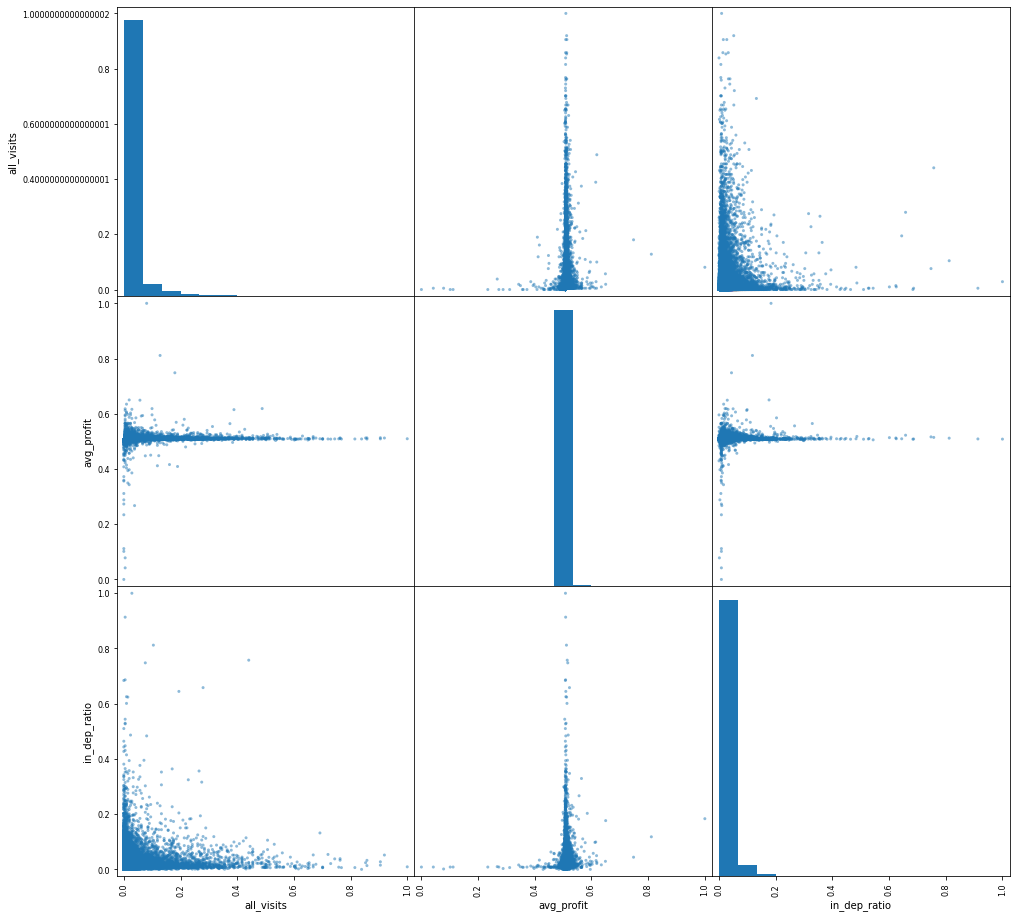

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df_matrix = clean_clients.loc[clean_clients['Ставки за бонусы (первое посещение)'] != 0,
                                             ['all_visits',
                                              'avg_profit',
                                             'in_dep_ratio']]

#min-max normalization
for col in df_matrix.columns:
    df_matrix[col] = (df_matrix[col] - df_matrix[col].min()
                     ) / (df_matrix[col].max() - df_matrix[col].min())

pd.plotting.scatter_matrix(df_matrix,
                          figsize=(16,16),
                          diagonal='hist',

                           hist_kwds={'bins':15})

Между кол-вом визитов и коэф. оборот/депо есть некоторая обратная нелинейная связь, похожая на экспоненциальную.

In [42]:
from scipy import optimize
import numpy as np

def test_func(x, a):
    return (np.exp(-a*x))

params, params_covariance = optimize.curve_fit(test_func, df_matrix['all_visits'],
                                               df_matrix['in_dep_ratio'])

print(params)

[786.88145639]


(-0.01, 1.0)

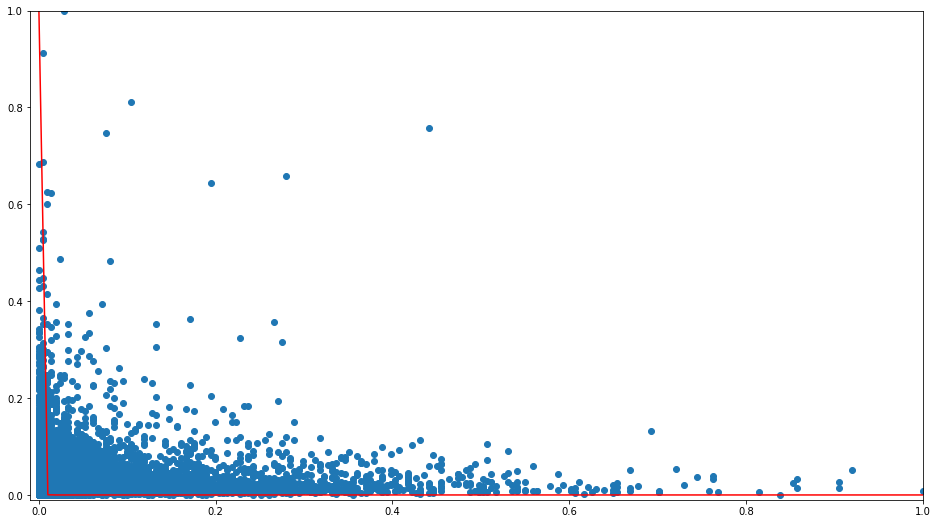

In [47]:
fig, ax = plt.subplots(figsize=(16,9))

ax.scatter(df_matrix['all_visits'],
           df_matrix['in_dep_ratio'])

x = np.linspace(0, 1, 100)

ax.plot(x,
         test_func(x, *params),
         label='Fitted function',
         c='red')

ax.set_xlim(-0.01, 1)
ax.set_ylim(-0.01, 1)

Весьма сомнительно, что тут действителньо экспонента, но тем не менее связь есть.

Используя её, можно разбить клиентов на два кластера:
* Те, кто больше ходят
* Те, кто больше ставят выигрыши

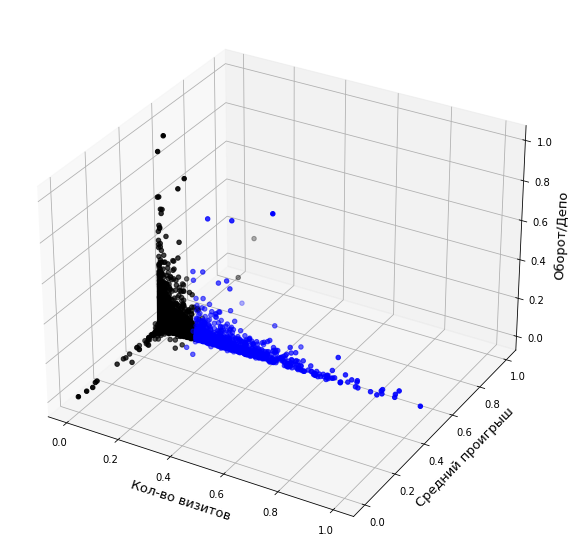

In [51]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2,
                n_init=50,
               random_state=0)

kmeans.fit(df_matrix)
df_matrix['cluster'] = kmeans.labels_

# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        ax.scatter(clustered_df['all_visits'],
                   clustered_df['avg_profit'],
                   clustered_df['in_dep_ratio'],
                   c=colors[n-1])
        
    ax.set_xlabel('Кол-во визитов', fontsize=13)
    ax.set_ylabel('Средний проигрыш', fontsize=13)
    ax.set_zlabel('Оборот/Депо', fontsize=13)
    plt.show()

visualize_clusters(df_matrix, 2)

In [52]:
clean_clients['client_type'] = kmeans.labels_
clean_clients.head()

,ID,Проигрыш (первое посещение),IN (первое посещение),Ставки за бонусы (первое посещение),Депозит (первое посещение),вывод средств (первое посещение),"№ клуба, который посетил в первый день регистрации в сети",1 day (день регистрации),2 day (день второго визита в клуб),max day (дата последнего визита),"Кол-во визитов (за все время, не считая 1й визит)",Проигрыш за все визиты,Ожидаемый проигрыш,all_visits,avg_profit,in_dep_ratio,client_type
2,2457572945,826800.0,2268210.0,600,856800.0,30000.0,70,2021-03-05,2021-03-07,2021-03-12,4,130560.000,405097.350,5,26112.000000,2.645451,0
8,2456983355,425400.0,2305488.0,250,425400.0,0.0,1367,2020-09-20,2020-09-21,2020-12-07,32,640380.000,158825.280,33,19405.454545,5.416394,1
14,2461534747,336000.0,336000.0,400,672000.0,336000.0,830,2021-03-06,NaT,NaT,0,0.000,0.000,1,0.000000,0.499703,0
16,2437471605,308040.0,1359900.0,450,308040.0,0.0,1731,2021-01-05,2021-01-06,2021-01-06,1,-2430.000,-2511.000,2,-1215.000000,4.408247,0
20,2456939549,276000.0,276900.0,500,276000.0,0.0,886,2020-10-23,2020-10-31,2020-11-27,7,-443019.372,16263.072,8,-55377.421500,1.001447,0


Агрегируем основные показатели по месяцам для новых клиентов.

In [53]:
clean_clients['month_year'] = clean_clients['1 day (день регистрации)'].dt.to_period('M')

clients_month = pd.DataFrame(clean_clients.groupby('month_year')['ID'].count())
clients_month.rename(columns={'ID': 'clients'}, inplace=True)

clients_month['depo'] = clean_clients.groupby('month_year')['Депозит (первое посещение)'].sum()
clients_month['withdraw'] = clean_clients.groupby('month_year')['вывод средств (первое посещение)'].sum()
clients_month['profit'] = clean_clients.groupby('month_year')['Проигрыш (первое посещение)'].sum()
clients_month['turnover'] = clean_clients.groupby('month_year')['IN (первое посещение)'].sum()

clients_month['profit_per_client'] = clients_month['profit'] / clients_month['clients']

clients_month

,clients,depo,withdraw,profit,turnover,profit_per_client
month_year,,,,,,
2020-07,2214,10811446.60,6691177.15,2.754841e+06,3.782412e+07,1244.282381
2020-08,3676,18460612.75,11602667.95,4.422047e+06,6.749178e+07,1202.950727
2020-09,4206,21249344.10,11840842.15,8.191389e+06,7.534234e+07,1947.548445
2020-10,3789,21908559.60,12606903.05,7.555358e+06,6.348464e+07,1994.024320
2020-11,3415,16319823.50,9318436.00,5.159116e+06,5.116975e+07,1510.722236
2020-12,3964,18519499.80,12232164.85,4.796408e+06,6.778368e+07,1209.992019
2021-01,3905,16373689.45,9313065.60,5.526940e+06,6.017367e+07,1415.349498
2021-02,3992,17372976.65,10672731.15,3.935424e+06,6.263016e+07,985.827598
2021-03,1352,8208091.60,4231423.30,2.793853e+06,2.326155e+07,2066.459229


In [54]:
clean_clients['1 day (день регистрации)'].max()

Timestamp('2021-03-11 00:00:00')

В марте 2021 всё заканчивается 11 числом, потому маленьнкие значения не должны смущать - ещё 2/3 месяца не учтены.

Построим графики для прибыли, кол-ва клиентов и средней прибыли на клиента (всё для первого посещения).

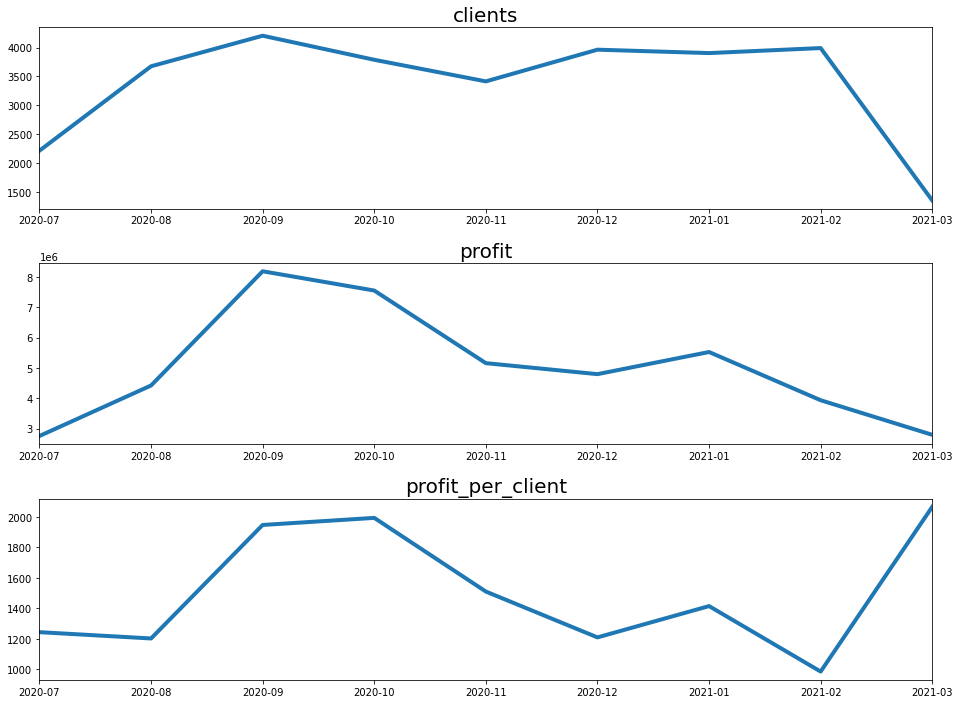

In [55]:
fig, axs = plt.subplots(3, 1, figsize=(16,12))
fig.subplots_adjust(hspace=0.3)

x = np.arange(0,len(clients_month),1)
columns = ['clients', 'profit', 'profit_per_client']

for i, col in enumerate(columns):
    axs[i].plot(x, clients_month[col],
                lw=4)
    
    axs[i].set_title(col, fontsize=20)
    axs[i].set_xticks(x)
    axs[i].set_xticklabels(clients_month.index)
    axs[i].set_xlim(0, len(clients_month)-1)

Из графиков видно, что прибыль падает с **сентября 2020** вплоть до **февраля 2021** (март не смотрим), хотя кол-во клиентов более-менее стабильно.

Посмотрим на депозиты за это время.

(0.0, 8.0)

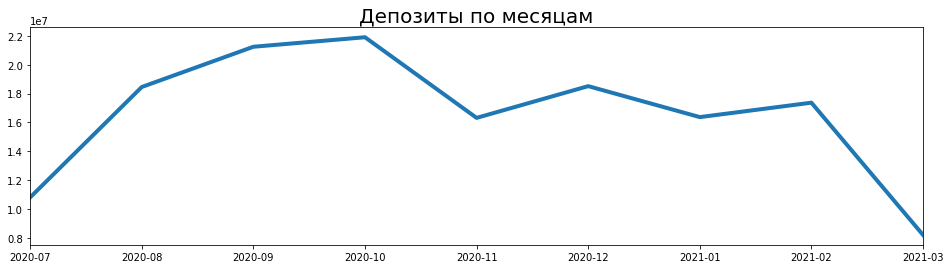

In [56]:
fig, ax = plt.subplots(figsize=(16,4))

ax.plot(x, clients_month['depo'],
                lw=4)
    
ax.set_title("Депозиты по месяцам", fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(clients_month.index)
ax.set_xlim(0, len(clients_month)-1)

Они тоже упали, но здесь несколько иной характер снижения. Нельзя сказать, что клиенты перестали вносить депозиты, они перестали ставить по другой причине.

Предположу, что всё это связано с сезонностью - август-сентябрь пришолся пик чемпионатов и игр. Людям было на что ставить, а значит и что проигрывать.